In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import os 
import string
import unicodedata

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import GRU, Dense,Input, SimpleRNN, Reshape, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau


In [117]:
## download the data

!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls 


# extract

In [20]:
allowed_chars = string.ascii_letters + ',.;"' + "_" ## this is our vocab  to filter the unknown words 
n_letters = len(allowed_chars)
n_letters

57

In [21]:
def unicodeASCII(s):
    return "".join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != "Mn" 
        and c in allowed_chars
    )

In [22]:
# e.g. a = '0'
def lettertoindex(letter):
    if letter not in allowed_chars:
        return allowed_chars.find('_')
    else:
        return allowed_chars.find(letter)

In [23]:
## array of one hot code letter
## <line_length * 1 * n_letters >
def linetotensor(padding_size,line):
    tensor = tf.zeros([padding_size, 1, n_letters], dtype=tf.float32)
    for li, letter in enumerate(line):
        tensor = tf.tensor_scatter_nd_update(tensor, [[li, 0, lettertoindex(letter)]], [1.0])

    return tensor

In [24]:
padding_size=19 ## 

In [25]:
label = []
data_tensor = []
data = []
labels = []
label_tensor = []
for filename in glob.glob('data/names/*.txt'):
    lang = os.path.basename(filename).split(".")[0]
    label.append(lang)

    lines = open(filename, encoding='utf-8').read().strip().split("\n")
    for name in lines: 
        data.append(unicodeASCII(name))
        data_tensor.append(linetotensor(padding_size,name))
        labels.append(lang)

        

In [26]:
label_to_index = {l: i for i, l in enumerate(label)}
label_tensor = tf.constant(
    [label_to_index[label] for label in labels], dtype=tf.int64
)

In [27]:
stack_tensor = tf.stack(data_tensor)
stack_tensor.shape

TensorShape([20074, 19, 1, 57])

In [28]:
label_tensor = tf.stack(label_tensor)
label_tensor.shape

TensorShape([20074])

In [29]:
X = tf.reshape(stack_tensor, [20074, 19, 57])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    stack_tensor.numpy(), label_tensor.numpy(), test_size=0.33, random_state=42)

In [31]:
X_train.shape

(13449, 19, 1, 57)

In [32]:
y_train.shape

(13449,)

In [33]:
model = tf.keras.Sequential([
    Input(shape=(19, 1, 57)),  # (seq_len, input_dim)
    Reshape((19,57)),
    GRU(128, return_sequences=True),
    GRU(64, return_sequences=False),  # collapse to a single vector
    Dense(18)  # logits for each character
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model using the datasets
history = model.fit(
    X_train,
    y_train,
    epochs=10
)

Epoch 1/10


2025-07-24 15:04:31.354827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5016 - loss: 1.7888
Epoch 2/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5615 - loss: 1.4355
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6417 - loss: 1.2225
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6922 - loss: 1.0778
Epoch 5/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7120 - loss: 0.9868
Epoch 6/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7473 - loss: 0.8516
Epoch 7/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7592 - loss: 0.7940
Epoch 8/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7976 - loss: 0.6837
Epoch 9/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8090 - loss: 0.6365
Epoch 10/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8092 - loss: 0.6150


In [34]:
model.evaluate(X_test, y_test)

208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8077 - loss: 0.6494   


[0.6504217982292175, 0.8072452545166016]

In [35]:
def final(string):
    x_tensor = tf.stack([linetotensor(19,string)]).numpy()
    
    print(x_tensor.shape)
    y_pred = model.predict(x_tensor)
    print(y_pred)
    print(np.max(y_pred))
    print(np.argmax(y_pred))
    print(label[np.argmax(y_pred)])

In [37]:
final("Lim")

(1, 19, 1, 57)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[ 0.8560317   1.5358819  -3.678173   -1.3073558   3.166499    1.4431534
   2.8836186  -0.16970715 -0.853975    1.872832   -1.594791   -5.8278213
  -2.9944756  -3.286798   -0.44954425  0.8594639   2.3807886  -0.6029743 ]]
3.166499
4
Chinese


In [38]:
final("Doan") ## vietnamese

(1, 19, 1, 57)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[-1.4320738  -0.23421931  0.8101196  -1.0053353   1.9245406   1.6501503
  -0.8048004   0.17018664  0.86441076  2.362224   -0.4632218  -3.470611
  -1.672115   -1.645464    0.63834655  0.51051444  0.9321553  -2.647535  ]]
2.362224
9
English


In [39]:
final("Blanchet") ### French

(1, 19, 1, 57)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[ 2.0409513   4.4533224  -3.2791214  -4.776714   -3.3670495  -2.6965394
   3.7987828   1.9304963   1.3126      4.350738   -1.5034257  -3.360139
  -2.6118236  -3.2294836   0.89208055  2.3163865  -3.815109   -0.89799297]]
4.4533224
1
German


In [40]:
final("Asghar")

(1, 19, 1, 57)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[-1.5512791   1.2216533   9.066005   -1.0540825  -1.7421452  -1.5050036
   0.09800085  0.6156283   1.1393691   2.5814714  -1.5241945  -1.8248608
  -2.1964374  -3.058744   -0.28902304 -0.85306704 -3.117776   -4.0447483 ]]
9.066005
2
Arabic


In [41]:
final("Chiba")

(1, 19, 1, 57)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[ 1.7345665  -1.4712     -0.7013244   3.8088145  -1.4036216  -2.8867974
   3.7853346  -1.6911079  -3.2057846   0.8119607   0.36692214 -2.6621525
   0.2035069  -1.0779388  -4.0033216  -2.0335743  -2.5826683  -1.000054  ]]
3.8088145
3
Japanese


In [45]:
final("Sai")

(1, 19, 1, 57)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[-0.068205   -0.86237097 -3.220135    2.8633046   2.635798    1.1689695
   0.97723424 -0.91806424 -0.960811   -0.546975    0.34671068 -4.5185823
   0.9581591  -0.18554457 -2.6950767  -0.92090595  2.6367922  -0.9806401 ]]
2.8633046
3
Japanese


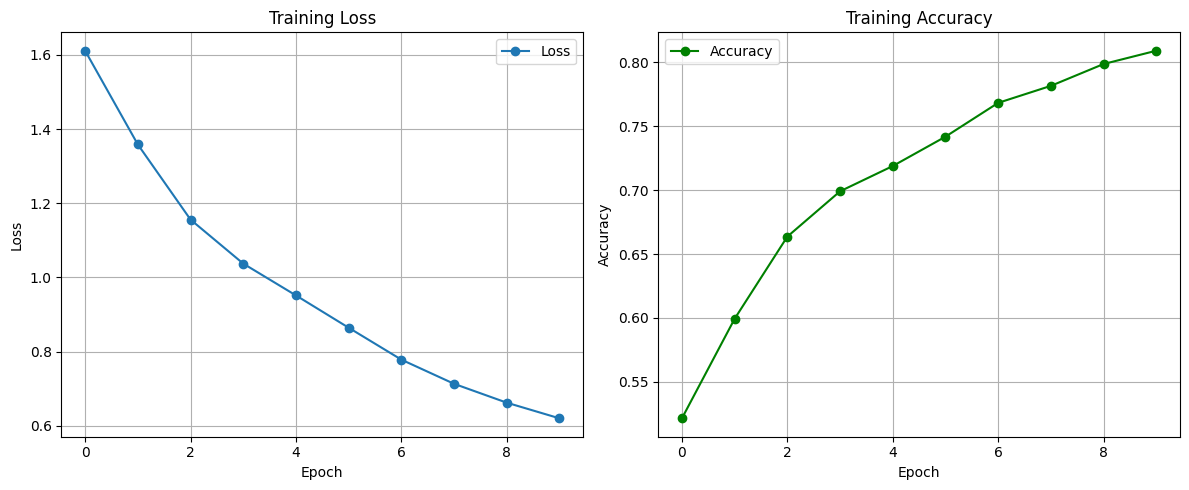

In [114]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot accuracy (if tracked)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy', color='green', marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()
